# CS337 - OPERATING SYSTEMS- Project 6 Software Synchronization
#### By: Matthew Bass


### Table of Contents

* [Overview](#over)
* [Setup](#set)
* [No Synchronization](#nosync)
* [Solution 1](#sol1)
* [Solution 2](#sol2)
* [Peterson's Solution](#solpet)
* [Bakery Solution](#solbak)
* [Filter Solution](#solfil)
* [Conclusion](#con)



**Project Overview:** <a class="anchor" id="over"></a>

In the project_6 file you I start by implementing a simple version of the
race condition, so I can test my synchronization solutions. In this file
 I will create well-designed simulations to test mutual exclusion, progress,
 bounded wait-time, and N-threads when possible.

The tests for each solution:

<img src="https://github.com/mattjax16/CS337-Operating-Systems/blob/258384ff2cd1c96a8a1e7aaaa5c22640627ea87c/Projects/Proj6/pics/test_reqs.png" />

To test the synchronization solutions the race conditions will be a global
counter that all the threads are incrementing. If the counter is the correct
number after all the threads are done working then we no the race condition
has been solved

A **race condition** is, a situation in which multiple threads or processes
read and write a shared data item and the final result depends on the
relative timing of their execution. So this is what we are going to be trying
 to prevent.


### PREREQUISITES:
    Python 3
    Jupyter
    jupyter_contrib_nbextensions
    Numpy
    threading
    datclasses
    autopep8


<br>

-----

### Setup: <a class="anchor" id="set"></a>

To start I am using this code to make all my code blocks hide-able, thanks to
[stackoverflow](https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer).


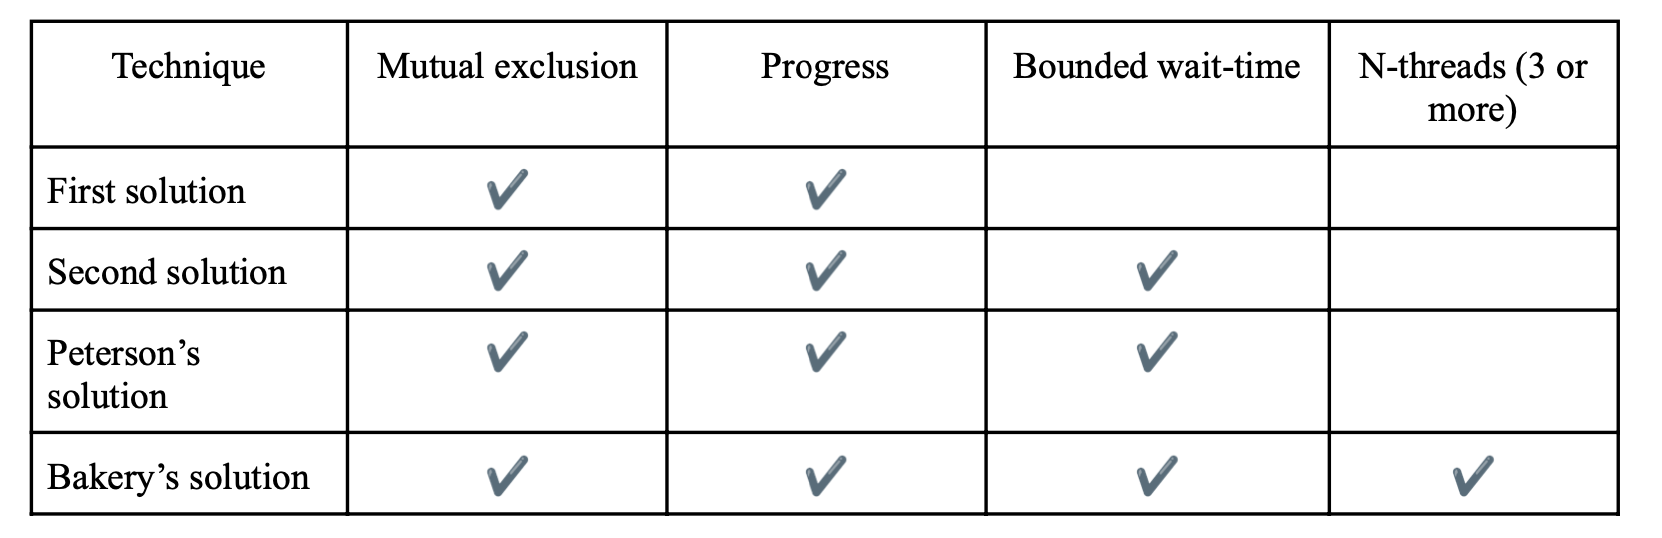

In [1]:
%%HTML
<script>
    function luc21893_refresh_cell(cell) {
        if( cell.luc21893 ) return;
        cell.luc21893 = true;
        console.debug('New code cell found...' );

        var div = document.createElement('DIV');
        cell.parentNode.insertBefore( div, cell.nextSibling );
        div.style.textAlign = 'right';
        var a = document.createElement('A');
        div.appendChild(a);
        a.href='#'
        a.luc21893 = cell;
        a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

        cell.style.visibility='hidden';
        cell.style.position='absolute';
        a.innerHTML = '[show code]';

    }
    function luc21893_refresh() {
        if( document.querySelector('.code_cell .input') == null ) {
            // it apeears that I am in a exported html
            // hide this code
            var codeCells = document.querySelectorAll('.jp-InputArea')
            codeCells[0].style.visibility = 'hidden';
            codeCells[0].style.position = 'absolute';
            for( var i = 1; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i].parentNode)
            }
            window.onload = luc21893_refresh;
        }
        else {
            // it apperas that I am in a jupyter editor
            var codeCells = document.querySelectorAll('.code_cell .input')
            for( var i = 0; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i])
            }
            window.setTimeout( luc21893_refresh, 1000 )
        }
    }

    function luc21893_toggle(a) {
        if( a.luc21893.style.visibility=='hidden' ) {
            a.luc21893.style.visibility='visible';
            a.luc21893.style.position='';
            a.innerHTML = '[hide code]';
        }
        else {
            a.luc21893.style.visibility='hidden';
            a.luc21893.style.position='absolute';
            a.innerHTML = '[show code]';
        }
    }

    luc21893_refresh()
</script>

#### Imports:

In [2]:
import threading
import time
import numpy as np
from dataclasses import field, dataclass
from abc import ABC, abstractmethod


#### Base Solution Class:
Now I am going to create an abstract class that will be used to make all the synchronization
solutions.

In [3]:
# Abstract class for all the solutions
class SyncSolution(ABC):

    def __init__(self) -> None:
        # Name of the solution (lock)
        self.name = None

        # Number of threads
        self.thread_count = None

        return

    @abstractmethod
    def lock(self) -> None:
        '''
        This method will be used to lock the solution.
        '''

        pass

    @abstractmethod
    def unlock(self) -> None:
        '''
        This method will be used to unlock the solution.
        '''
        pass

#### Base Testing:
To test the different solutions I am going to write the single main function that will increment the
global counter x INC_AMTS times. It will run the function over the
NUM_THREADS specified and will use the solution specified. Also, it will run
tests for mutual exclusion, progress, bounded wait-time, and N-threads when specified.


##### Starting Global Counter Variable:

In [4]:
# Setting global var x to 0
x = 0



##### Increment Function:

In [5]:
def increment():
    '''
    This function will be used to increment the global variable x
    Returns:
    '''
    # Get the global counter x
    global x

    # Increment the global counter x
    x += 1


<br>

##### Testing Functions:
Now I will write the three different helper functions for `thread_task` that
will be used to test the different aspects of a good synchronization solution.
Those being, mutual exclusion, progress, bounded wait-time. (We will also
test some solutions to see if they work with N-threads but this is just done
by changing the `thread_count` variable).

<br>

###### Mutual Exclusion:
Mutual exclusion is the ability to ensure that only one thread is executing a
 given critical section of code at a time. In more formal terms from our
 notes it is "The requirement that when one process is in a critical section
 that accesses shared resources, no other process may be in a critical
 section that accesses any of those shared resources". In the context of this
  testing the critical section is the `increment` function. because to
  increment the thread must first read the value of the global variable x and
   then add 1 to it so it is possible for another thread to increment the
   counter x while the first thread is incrementing it. This can lead to inconsistent
    and unexpected results. If a synchronization solution is not able to
     ensure mutual exclusion then it is not really a solution at all.

To validate if a count is correct (and there for mutual exclusive, as long as
 the count is great enough) I wrote `check_result` below:

In [6]:
def check_result(result: int, 
                 inc_amts: list) -> bool:
    '''
    This function will check the result of the the x output for the main_tasks

    Args:
        result (int): The result of the x output from the main_task
        inc_amts (list): The list of increments that were done per thread

    Returns:
        bool: True if the result is correct, False otherwise
    '''
    if result == sum(inc_amts):
        return True
    else:
        return False

<br>

Then the helper function `thread_task` to check `me` is written below:

In [7]:
def thread_task_me(lock: SyncSolution, 
                   thread_id: int, 
                   inc_amt: int,
                   debug: bool = False) -> None:
    '''
    This function will be used to test for mutual exclusion.

    Args:
        lock (SyncSolution): The solution to test
        thread_id (int): The id of the thread
        inc_amt (int): The amount of times to increment the global counter x
        debug (bool): If True, will print the results of the test

    Returns:
        None
    '''
    # Lock the solution
    lock.lock(thread_id, debug)

    # Increment the global counter x
    for i in range(inc_amt):
        #         # Forcing a context switch
        #         time.sleep(0.0000000001)

        increment()

    # Unlock the solution
    lock.unlock(thread_id, debug)

    return


<br>

###### Progress:
Progress means that only threads that need the shared resource should participate in the
decision to access it.  If no process is executing in its critical section
and some processes wish to enter their critical sections, then only those
processes that are not executing in their remainder section can participate
in deciding which will enter its critical section next, and this selection
cannot be postponed  indefinitely. Basically no dead-lock or live-lock can
occur.

*dead-lock:* A situation in which two or more processes are unable to proceed
 because each is waiting for one of the others to do something.

*live-lock:* A situation in which two or more processes continuously change their state in response to changes in the other process(es) without doing any useful work.

Below is the code I wrote to test for progress it locks and unlocks within
the loop to cause more thread switches and cause the threads to have to be
locked and unlocked multiple times. It also then has extra work at the end of
 each thread to have them working on data that is independent of the other.

In [8]:
def thread_task_prog(lock: SyncSolution, 
                     thread_id: int, 
                     inc_amt: int,
                     lock_in_loop: bool = True,
                     debug: bool = False) -> None:
    '''
    This function will be used to test for progress.

    Args:
        lock (SyncSolution): The solution to test
        thread_id (int): The id of the thread
        inc_amt (int): The amount of times to increment the global counter x
        lock_in_loop (bool): If True, will lock and unlock in the loop
        debug (bool): If True, will print the results of the test

    Returns:
        None
    '''

    if lock_in_loop:
        # Increment the global counter x
        for i in range(inc_amt):
            # Lock the solution
            lock.lock(thread_id,debug)

            increment()

            # Unlock the solution
            lock.unlock(thread_id,debug)
    else:
        # Lock the solution
        lock.lock(thread_id,debug)

        # Increment the global counter x
        for i in range(inc_amt):
            increment()

        # Unlock the solution
        lock.unlock(thread_id,debug)

    prog_check = 0
    for _ in range(inc_amt * 5):
        prog_check += 1

    # if debug:
    #     print(f'Thread {thread_id} is done')

    return

<br>

###### Bounded Wait Time (BWT):
Bounded wait time basically means that a ready thread should not wait forever.
In more formal terms it means, there exists a bound, or limit, on the number
of times other processes are allowed to enter their critical sections after a
 process has made request to enter its critical section and before that
 request is granted. The purpose of this condition is to make sure that every
  process gets the chance to actually enter its critical section so that no
  process starves forever. (Preventing starvation)


*starvation:* A situation in which a runnable process is overlooked
indefinitely by the scheduler; although it is able to proceed, it is never chosen.

To test for BWT I used the same time as the progress test but instead of
calling the normal `lock()` function I used the `lockSleep()` function which
uses the function `time.sleep(0.001)` to force contex switched while the
thread is locking.

Here is the helper function `thread_task_bwt()` below:

In [9]:
def thread_task_bwt(lock: SyncSolution,
                    thread_id: int, 
                    inc_amt: int, 
                    lock_in_loop: bool = True, 
                    debug: bool = False) -> None:
    '''
    This function will be used to test for progress.

    Args:
        lock (SyncSolution): The solution to test
        thread_id (int): The id of the thread
        inc_amt (int): The amount of times to increment the global counter x
        lock_in_loop (bool): If True, will lock and unlock in the loop
        debug (bool): If True, will print the results of the test

    Returns:
        None
    '''
    if lock_in_loop:
        # Increment the global counter x
        for i in range(inc_amt):
            # Lock the solution
            lock.lock(thread_id,debug)

            increment()

            # Unlock the solution
            lock.unlock(thread_id,debug)
    else:

        # Lock the solution
        lock.lock(thread_id,debug)

        # Increment the global counter x
        for i in range(inc_amt):
            increment()

        # Unlock the solution
        lock.unlock(thread_id,debug)


    prog_check = 0
    for _ in range(inc_amt * 10):
        prog_check += 1

    # if debug:
    #     print(f'Thread {thread_id} is done')

    return

##### Thread Task Functions:
Now I am going to make the main thread task function which will increment the
global counter x, inc_amt times. It will run the function over the
NUM_THREADS specified and will use the solution specified. Also, it will run
tests for mutual exclusion, progress, bounded wait-time, and N-threads when specified.

In [10]:
def thread_task(lock: SyncSolution = None, 
                thread_id: int = 0, 
                inc_amt: int = 100000,
                test:str = "me",
                debug: bool = False):
    '''
    This is the thread task that will be used to test the software
    synchronization solutions.

    Args:
        lock (SyncSolution): The lock that will be used to synchronize
        thread_id (int): The number that will be used to synchronize (the thread number)
        inc_amt (int): The amount that will be used to increment the global variable x
        test (str): The test that we will be doing to determine what code to run
        debug (bool): If the debug flag is set to True, then the debug
    '''

    # If the SyncSolution is not specified, then we will use the default
    if lock is None:
         # If there is no lock, then just increment the global x variable
        for _ in range(inc_amt):
            
#             # Forcing a context switch
#             time.sleep(0.0000000001)
            
            increment()

        if debug:
            print(f'Thread {thread_id} is done')
        return

    # If the test is me, then we will run the main_task
    if test == "me":
        thread_task_me(lock, thread_id, inc_amt, debug)

    # If not mutual exclusion but is progress check do more thread switching
    # (and locked and unlocking) for each increment so they have to rely on
    # each other .
    elif test == "prog":

        # lock is in the increment loop or not depending if thread is even or
        # odd
        if thread_id %2 == 0:
            thread_task_prog(lock, thread_id, inc_amt, True, debug)
        else:
            thread_task_prog(lock, thread_id, inc_amt,False,debug)

    # If testing for bounded wait time use the lockSleep method which is the
    # same as the lock method but induces contex switches by calling
    # time.sleep(0.0001)
    elif test == "bwt":

        # lock is in the increment loop or not depending if thread is even or
        # odd
        if thread_id %2 == 0:
            thread_task_bwt(lock, thread_id, inc_amt, True, debug)
        else:
            thread_task_bwt(lock, thread_id, inc_amt,False,debug)



    return

##### Simulation Functions:

Now I am going to write the functions for the simulation

To start I am going to write the `single_sim()` function which runs the thread
count simulation once.

In [11]:
def single_sim(solution: SyncSolution = None,
               inc_amt: int = 100000,
               thread_count = 2 ,
               thread_multiplier = None,
               test: str = "me",
               debug: bool = False) -> int:
    '''
    This is the single_simulation that will be used to test the
    software synchronization solutions.

    Args:
        solution (SyncSolution): The lock that will be used to synchronize
        inc_amt (int): The amount that will be used to increment the global variable x
        thread_count (int): The number of threads that will be used
        thread_multiplier (list): The multiplier of the increment amount for each thread
        test (str): The test that we will be doing to determine what code to run
        debug (bool): If the debug flag is set to True, then the debug

    Returns:
        int: The result of the x output from the main_task

    '''

    global x

    # set x to 0
    x = 0

    # Check the thread_multiplier
    if thread_multiplier is None:
        thread_multiplier = [1] * thread_count
    elif len(thread_multiplier) != thread_count:
        raise ValueError(f"The thread_multiplier must be the same length as the thread_count")

    inc_amts = [inc_amt * x for x in thread_multiplier]

    # If the lock is not None then initilize it
    if solution is not None:
        lock = solution(thread_count = thread_count)
    else:
        lock = None

    # Create threads
    threads = []
    for thread_num in range(1, thread_count + 1):
        thread = threading.Thread(target=thread_task,
                                  args=(
                                  lock, thread_num, inc_amts[thread_num - 1], test, debug))

        threads.append(thread)

    # Start threads
    for thread in threads:
        thread.start()

    # Wait for threads to finish
    for thread in threads:
        thread.join()

    return x

<br>

Before I write the function to run the simulation multiple times I am going
to write a helper function, `check_results()` to check the results of each
simulation.

In [12]:
def check_results(results: list, inc_amts: list) -> bool:
    '''
    This function will check the results of the the x outputs for the main_tasks

    Args:
        results (list): The list of results from the main_tasks
        inc_amts (list): The list of increment amounts used in the main_tasks

    Returns:
        bool: True if the results are correct, False otherwise
    '''
    for result in results:
        if not check_result(result["x"], inc_amts):
            return False
    return True


<br>

Now I am going to write the `main_simulations()` function which will run the
simulation for the times specified, along with all the other arguments that
there are for a single simulation.

In [13]:
def main_simulations(solution: SyncSolution = None,
                     inc_amt: int = 100000,
                     thread_count = 2 ,
                     thread_multiplier = None,
                     test: str = "me",
                     debug: bool = False,
                     times: int = 10) -> None:
    """
    This is the main function that will be used to test the
    software synchronization solutions.r

    Args:
        solution (SyncSolution): The lock that will be used to synchronize
        times (int): The number of times that the simulation will be run
        inc_amt (int): The amount that will be used to increment the global variable x
        thread_count (int): The number of threads that will be used
        thread_multiplier (list): The multiplier of the increment amount for each thread
        test (str): The test that we will be doing to determine what code to run
        debug (bool): If the debug flag is set to True, then the debug



    Returns:
        None:

    """

    global x

    # set x to 0
    x = 0

     # Check the thread_multiplier
    if thread_multiplier is None:
        thread_multiplier = [1] * thread_count
    elif len(thread_multiplier) != thread_count:
        raise ValueError(f"The thread_multiplier must be the same length as the thread_count")

    inc_amts = [inc_amt * x for x in thread_multiplier]


    # Run the simulation times
    simulation_results = []
    for i in range(times):
        # Run the main task
        single_sim(solution, inc_amt, thread_count, thread_multiplier, test, debug)



        # Append the results to the list
        simulation_results.append({'iteration': i, 'x': x})

    # Check the results
    if check_results(simulation_results, inc_amts):
        print('\nAll results are correct!')

    # Else print the results that are incorrect
    else:
        print('\nThe results are incorrect!')

    # Print what the correct result should be
    print(f"The correct result should be {sum(inc_amts)}")

    # Print the results
    print('\nThe results are:')
    for result in simulation_results:
        print(f'Iteration {result["iteration"]+1}: x = {result["x"]}')

    return

<br>

### Testing Simulation With No Synchronization: <a class="race" id="nosync"></a>

Now that all the base code is done time to test it all out by trying to run
the simulation with no form of synchronization. A race condition should occur
 with the count not being correct (showing it isn't mutually exclusive at all)


In [14]:
main_simulations(inc_amt=500000)



The results are incorrect!
The correct result should be 1000000

The results are:
Iteration 1: x = 885503
Iteration 2: x = 650651
Iteration 3: x = 763254
Iteration 4: x = 823736
Iteration 5: x = 970355
Iteration 6: x = 849933
Iteration 7: x = 769336
Iteration 8: x = 885225
Iteration 9: x = 769351
Iteration 10: x = 884625


From the results above we can see that the simulation is working and with no
synchronization solution a race condition with the count being incorrect can
occur.

<br>

### Solution 1: <a class="anchor" id="sol1"></a>

This is the first solution to the project.

I  will implement the first synchronization attempt from lecture slides
(lecture 12) using a Python class that implements the following:

- An `__init__` method that initializes a turn variable.

- A lock method that takes a thread_id as an argument. The method should
   behave according to the pseudocode in lecture slides.

- An unlock method that takes a thread_id, and uses it to change the
   value of turn according to the pseudocode in lecture slides.

The main idea of this solution is that there is a single variable turn that
is used to make sure the thread only enters the critical section when it is its turn.
This ensures mutual exclusion but not progress and therefore neither bounded
wait time as we will see later.

**Here is the code for the solution class:**

In [15]:
@dataclass
class Solution1(SyncSolution):
    '''
    This is the first solution to the project.

    Initialize the turn variable.

        Args:
            turn (int): The initial value of the turn variable.

    '''
    turn: int = field(default=1)
    name: str = field(default='1')
    thread_count: int = field(default=2)

    def lock(self, thread_id : int, debug : bool = True) -> None:
        '''
        This method implements the first synchronization attempt from lecture slides
        (lecture 12).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')
        while self.turn != thread_id:
            pass

        if debug:
            print(f'Thread {thread_id} acquired the lock.')
            print(f'Turn is {self.turn}')

    def unlock(self, thread_id : int, debug : bool = True) -> None:
        '''
        This method implements the first synchronization attempt from lecture slides
        (lecture 12).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides. All it does is change the
        value of turn according to thread_id being unlocked.

        Args:
            thread_id (int): The thread_id of the thread that is trying to
            release the lock of.
            debug (bool): If True, print the value of turn after the unlock.
        '''

        # Change self.turn to the next thread_id (between 1 or 2)
        if self.turn == 1:
            self.turn = 2
        else:
            self.turn == 2
            
        if debug:
            print(f"Thread {thread_id} released the lock.")

##### Solution 1 Mutual Exclusion Test:
Now that we have the solution class we can test for mutual exclusion using
the `main_simulations()` function.

In [16]:
main_simulations(inc_amt=500000, solution=Solution1)



All results are correct!
The correct result should be 1000000

The results are:
Iteration 1: x = 1000000
Iteration 2: x = 1000000
Iteration 3: x = 1000000
Iteration 4: x = 1000000
Iteration 5: x = 1000000
Iteration 6: x = 1000000
Iteration 7: x = 1000000
Iteration 8: x = 1000000
Iteration 9: x = 1000000
Iteration 10: x = 1000000


From the results above we can see that solution 1 passes the mutual exclusion
test since all the counts are correct.

<br>

##### Solution 1 Progress Test:

Since we have confirmed mutual exclusion, we can now test for progress, for
solution 1, using the `main_simulations()` function.

In [17]:
# main_simulations(inc_amt=10, solution=Solution1,  thread_multiplier=[1,4] ,
#                  test='prog', debug=True)


From here we can see that this solution fails the progress test as the
threads end up waiting indefinitely for each other causing the function to
never finish. Since solution 1 failed the progress test, there is no need to
test for bounded wait time.

<br>

### Solution 2: <a class="anchor" id="sol2"></a>

This is the second solution to the project.

I will implement the second synchronization attempt from lecture slides
(lecture 13) using a Python class that implements the following:

- An `__init__` method that initializes a flags list.

- A lock method that takes a thread_id as an argument. The method should
    behave according to the pseudocode in lecture slides.

- An unlock method that takes a thread_id, and uses it to change the
    value of flags according to the pseudocode in lecture slides.

The main idea of this solution is that instead of using a single variable
turn, a flags array is used which is initialized to all False. When a thread
wants to work on the critical section a flag is raised, and it checks that the
 other thread has not raised its flag, meaning it is working on the critical
 section. If the other thread has its flag raised, the thread trying to lock
 will wait until the other thread has left the critical section which is
 signaled by its flag being set to false. (this is not an actual signal though
  and is really a variable held by the lock)

**Here is the code for the solution class:**

In [18]:
@dataclass
class Solution2(SyncSolution):
    '''
    This is the second solution to the project.
    '''

    flags: int = field(default_factory=lambda: [False] * 2)
    name: str = field(default="2")
    thread_count: int = field(default=2)

    def lock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the second synchronization attempt from lecture slides
        (lecture 13).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1
        other_thread = thread_idx ^ 1

        self.flags[thread_idx] = True
        while self.flags[other_thread]:
            pass

        # IF DEBUG PRINT THAT THE THREAD HAS LOCKED
        if debug:
            print(f'Thread {thread_id} has locked')

    def lockSleep(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method is the same as lock but used to force a contex switch by having
        time.sleep() in the lock method.


        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1
        other_thread = thread_idx ^ 1

        self.flags[thread_idx] = True

        # FORCE A CONTEXT SWITCH
        time.sleep(0.0001)

        while self.flags[other_thread]:
            pass
        if debug:
            print(f'Thread {thread_id} has locked')

    def unlock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the second synchronization attempt from lecture slides
        (lecture 13).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides. All it does is change the
        value of turn according to thread_id being unlocked.

        Args:
            thread_id (int): The thread_id of the thread that is trying to
            release the lock of.
            debug (bool): If True, print the value of turn after the unlock.
        '''
        thread_idx = thread_id - 1
        self.flags[thread_idx] = False

        if debug:
            print(f"Thread {thread_id} released the lock.")

##### Solution 2 Mutual Exclusion Test:
Now that we have the solution class we can test for mutual exclusion using
the `main_simulations()` function.

In [19]:
main_simulations(inc_amt=500000, solution=Solution2)



All results are correct!
The correct result should be 1000000

The results are:
Iteration 1: x = 1000000
Iteration 2: x = 1000000
Iteration 3: x = 1000000
Iteration 4: x = 1000000
Iteration 5: x = 1000000
Iteration 6: x = 1000000
Iteration 7: x = 1000000
Iteration 8: x = 1000000
Iteration 9: x = 1000000
Iteration 10: x = 1000000


From the results above we can see that solution 2 passes the mutual exclusion
test since all the counts are correct.

<br>

##### Solution 2 Progress Test:

Since we have confirmed mutual exclusion, we can now test for progress, for
solution 2, using the `main_simulations()` function.

In [20]:
main_simulations(inc_amt=500000, solution=Solution2,  thread_multiplier=[1,4]
                 ,test='prog')



All results are correct!
The correct result should be 2500000

The results are:
Iteration 1: x = 2500000
Iteration 2: x = 2500000
Iteration 3: x = 2500000
Iteration 4: x = 2500000
Iteration 5: x = 2500000
Iteration 6: x = 2500000
Iteration 7: x = 2500000
Iteration 8: x = 2500000
Iteration 9: x = 2500000
Iteration 10: x = 2500000


From here we can see that solution 2 passes the progress test since the
simulation completed with correct results.

<br>

##### Solution 2 Bounded Wait Time Test:

Since we have confirmed progress, we can now test for bounded wait time, for
solution 2, using the `main_simulations()` function.

In [21]:
# main_simulations(inc_amt=10000, solution=Solution2,  thread_multiplier=[1,4] ,
#                  test='bwt', debug=True)

From this test we can see that solution 2 fails the bounded wait time test as
both threads are waiting for each other. forcing the entire function to stop
and wait indefinitely.

<br>

### Peterson's Solution <a class="anchor" id="solpet"></a>

This is the Peterson's solution to the project.(uses flags and turn)

In this solution class I will implement Peterson’s
synchronization solution from lecture slides (lecture 13) using a Python
class that implements the following:

        ● An __init__ method that initializes a flags list and a turn variable.

        ● A lock method that takes a thread_id as an argument. The method
        should behave according to the pseudocode in lecture slides.

        ● An unlock method that takes a thread_id, and uses it to change the
        value of flags according to the pseudocode in lecture slides.

The algorithm uses two variables: `flag` and `turn`. A `flag[n]` value of
true indicates that the process n wants to enter the critical section.
Entrance to the critical section is granted for process P0 if P1 does not
want to enter its critical section or if P1 has given priority to P0 by
setting turn to 0.

The algorithm satisfies the three essential criteria to solve the
critical-section problem. The while condition works even with preemption. The
 three criteria are mutual exclusion, progress, and bounded waiting.


Here is the solution class (It acts differently depending on the number of
threads):

In [22]:
class SolutionPeterson(SyncSolution):
    '''
    This is the Peterson's solution to the project.(uses flags and turn)
    '''

    def __init__(self, thread_count: int = 2) -> None:
        '''
        This method initializes the name turn and flags array

        Args: thread_count (int): The number of threads that will be using the
        Bakery Solution.

        Returns:
            None
        '''
        self.name = 'peterson'
        self.turn = 0
        self.flags = np.zeros(thread_count, dtype=bool)
        self.thread_count = thread_count

    def lock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the Petersons synchronization attempt from lecture slides
        (lecture 13).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        if self.thread_count == 2:
            # Get thread id and other thread id
            thread_idx = thread_id - 1
            other_thread = thread_idx ^ 1

            # Set flag
            self.flags[thread_idx] = True

            # Set turn
            self.turn = other_thread

            # Wait for other thread to release lock
            while self.flags[other_thread] and self.turn == other_thread:
                pass

        elif self.thread_count > 2:

            # Get thread id and other thread id
            thread_idx = thread_id - 1
            other_thread_r = (thread_idx + 1) % self.thread_count
            other_thread_l = (thread_idx + 1) % self.thread_count

            # Set flag
            self.flags[thread_idx] = True

            # Set turn
            self.turn = other_thread_r

            # Wait for other thread to release lock
            while self.flags[other_thread_r] and self.flags[other_thread_l] and \
                    self.turn == other_thread_r:
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def lockSleep(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method is the same as lock but used to force a contex switch by having
        time.sleep() in the lock method.


        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        if self.thread_count == 2:
            # Get thread id and other thread id
            thread_idx = thread_id - 1
            other_thread = thread_idx ^ 1

            # Set flag
            self.flags[thread_idx] = True

            # Forcing a context switch
            time.sleep(0.0001)

            # Set turn
            self.turn = other_thread

            # Forcing a context switch
            time.sleep(0.0001)

            # Wait for other thread to release lock
            while self.flags[other_thread] and self.turn == other_thread:
                pass

        elif self.thread_count > 2:

            # Get thread id and other thread id
            thread_idx = thread_id - 1
            other_thread_r = (thread_idx + 1) % self.thread_count
            other_thread_l = (thread_idx + 1) % self.thread_count

            # Set flag
            self.flags[thread_idx] = True

            # Forcing a context switch
            time.sleep(0.0001)

            # Set turn
            self.turn = other_thread_r

            # Forcing a context switch
            time.sleep(0.0001)

            # Wait for other thread to release lock
            while self.flags[other_thread_r] and self.flags[
                    other_thread_l] and self.turn == other_thread_r:
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def unlock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the Peterson's synchronization attempt from lecture slides
        (lecture 13).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides. All it does is change the
        value of turn according to thread_id being unlocked.

        Args:
            thread_id (int): The thread_id of the thread that is trying to
            release the lock of.
            debug (bool): If True, print the value of turn after the unlock.
        '''
        thread_id -= 1
        self.flags[thread_id] = False

        if debug:
            print(f"Thread {thread_id+1} released the lock.")


##### Peterson's Solution Mutual Exclusion Test:
Now that we have the solution class we can test for mutual exclusion using
the `main_simulations()` function.

In [23]:
main_simulations(inc_amt=500000, solution=SolutionPeterson)



All results are correct!
The correct result should be 1000000

The results are:
Iteration 1: x = 1000000
Iteration 2: x = 1000000
Iteration 3: x = 1000000
Iteration 4: x = 1000000
Iteration 5: x = 1000000
Iteration 6: x = 1000000
Iteration 7: x = 1000000
Iteration 8: x = 1000000
Iteration 9: x = 1000000
Iteration 10: x = 1000000


From the results above we can see that peterson's solution passes the mutual
exclusion
test since all the counts are correct.

<br>

##### Peterson's Solution Progress Test:

Since we have confirmed mutual exclusion, we can now test for progress, for
peterson's solution, using the `main_simulations()` function.

In [24]:
main_simulations(inc_amt=500000, solution=SolutionPeterson,
                 thread_multiplier=[1,4] ,
                 test='prog')



All results are correct!
The correct result should be 2500000

The results are:
Iteration 1: x = 2500000
Iteration 2: x = 2500000
Iteration 3: x = 2500000
Iteration 4: x = 2500000
Iteration 5: x = 2500000
Iteration 6: x = 2500000
Iteration 7: x = 2500000
Iteration 8: x = 2500000
Iteration 9: x = 2500000
Iteration 10: x = 2500000


From here we can see that peterson's solutionpasses the progress test since the
simulation completed with correct results.

<br>

##### Peterson's Solution Bounded Wait Time Test:

Since we have confirmed progress, we can now test for bounded wait time, for
peterson's solution, using the `main_simulations()` function.

In [25]:
main_simulations(inc_amt=500000, solution=SolutionPeterson,
                 thread_multiplier=[1,4] ,
                 test='bwt')


All results are correct!
The correct result should be 2500000

The results are:
Iteration 1: x = 2500000
Iteration 2: x = 2500000
Iteration 3: x = 2500000
Iteration 4: x = 2500000
Iteration 5: x = 2500000
Iteration 6: x = 2500000
Iteration 7: x = 2500000
Iteration 8: x = 2500000
Iteration 9: x = 2500000
Iteration 10: x = 2500000



From this test we can see that peterson's solution satisfies the bounded wait
 time test, since all the counts are correct with context switches happening
 during the locking function.

<br>

##### Peterson's Solution N-Threads Test:

Since we have confirmed progress, we can now test for the use of n-theads (in
 this case 3 threads), for  peterson's solution, using the `main_simulations
 ()` function.

In [26]:
main_simulations(inc_amt=50000, solution=SolutionPeterson,
                 thread_multiplier=[1,4, 8] , test='me', thread_count=3)


The results are incorrect!
The correct result should be 650000

The results are:
Iteration 1: x = 590809
Iteration 2: x = 533968
Iteration 3: x = 591645
Iteration 4: x = 650000
Iteration 5: x = 533637
Iteration 6: x = 650000
Iteration 7: x = 566775
Iteration 8: x = 650000
Iteration 9: x = 592357
Iteration 10: x = 650000


From this test with 3 threads we can see that the peterson's solution does
not work with n-threads (more than 2 threads). This is shown because the
count is off for some iterations (meaning a race condition has occurred).
This happens now because the code is running in parallel not concurrently.
This then leads to a problem because the code to spin in the solution

```{python}
while self.flags[other_thread_r] and \
        self.flags[other_thread_l] and \
        self.turn == other_thread_r:
            pass
```

Is not an atomic operation which is: *A function or action implemented as a
sequence of one or more instructions that appears to be indivisible; that is,
 no other process can see an intermediate state or interrupt the operation.
 The sequence of instruction is guaranteed to execute as a group, or not
 execute at all, having no visible effect on system state. Atomicity
 guarantees isolation from concurrent processes.*

Because this code does not guarantee isolation from other threads, some
threads will end up running in parallel in the critical section causing the
race condition.


<br>


### Bakery Solution: <a class="anchor" id="solbak"></a>

This is the bakery solution to the project.

I will implement the bakery synchronization solution from lecture slides
(lecture 14) using a Python class that implements the following:

- An `__init__` method that takes a thread_count and initializes a choosing
list and a tickets list.

- A lock method that takes a thread_id as an argument. The method should
behave according to the pseudocode in lecture slides.


- An unlock method that takes a thread_id and behaves according to the
pseudocode in lecture slides.


The purpose of bakery algorithm is to synchronize the execution of multiple
threads (more than 2). The Bakery algorithm is one of the simplest known
solutions to synchronize N threads. Its is called the bakery algorithm
because it is modeled after the idea of how a bakery ticket counter works.
Think of how a bakery has a ticket number machine that that gives each
customer a ticker number when they enter (in this case the threads are the
customers). Numbers increase by one as customers enter the store (in this
algorithm the threads get a ticket number when they want to enter the
critical section ). A global counter displays the number of the customer that
 is currently being served (in the context of this is the `choosing` list
 which is has true in the position of which thread is accessing the critical
 section, acts as a doorway step).
 All other customers
must wait in a queue until the baker finishes serving the current customer
and the next number is displayed. When the customer is done shopping and has
disposed of his or her number, the clerk increments the number, allowing the
next customer to be served (This is unlocking the thread). That customer must
draw another number from the numbering machine in order to shop again.

In this bakery solution class the reasoning for having a chossing array that
is the length of the thread_count and also a tickets array which holds the
ticket number for each thread is due to the fact that the function for
assigning a ticket number to the thread being locked is not atomic (` self
.tickets[thread_idx] = np.max(self.tickets) + 1`), getting the max of the
array is really iterating over every entry and reading it so this leads to it
 being possible that 2 or more threads could enter the critical section at
 the same time if they both calculate the same ticket number if a
 higher-priority process was preempted before setting the ticket number the
 low-priority process will see that the other process has a number of zero,
 and enter the critical section; later, the high-priority process will
 ignore the equal ticket number for lower-priority processes, and also enters
 the critical section. SO by using the `choosing` array it makes the code for
  choosing a ticket number 'seem' atomic. This is because we wait for all threads to be done picking a
  ticker number before the critical section for the thread that is using the
  lock is ran. This is also ensured because when comparing ticket numbers
  between threads if they at one point do have the same ticket number then
  they are compared based off their thread_id.


Here is the code for the bakery solution class:

In [27]:
class SolutionBakery(SyncSolution):
    '''
    This is the Bakery Solution. It uses two np.arrays a choosing array and a
    tickets array.
    '''

    def __init__(self, thread_count: int) -> None:
        '''
        This method initializes a choosing array and a tickets array.

        Args: thread_count (int): The number of threads that will be using the
        Bakery Solution.

        Returns:
            None
        '''

        # Initialize thread count
        self.thread_count = thread_count

        # Initialize choosing array
        self.choosing = np.zeros(thread_count, dtype=bool)

        # Initialize tickets array
        self.tickets = np.zeros(thread_count, dtype=int)

    def lock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implement Bakery’s synchronization solution from lecture
        slides (lecture 14)

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1

        # The Doorway

        # Choosing variable to be TRUE indicating its intent to enter critical
        # section.
        self.choosing[thread_idx] = True

        # Set tickets array to the highest ticket number corresponding to other
        # processes.
        self.tickets[thread_idx] = np.max(self.tickets) + 1

        # Set the choosing variable is set to FALSE indicating that it now has
        # a new ticket number.
        self.choosing[thread_idx] = False

        # The entry part of the lock
        for p in range(self.thread_count):

            # Wait until thread p receives its number:
            while self.choosing[p]:
                pass

            # Then first the ticket number is compared. If they are the same
            # then the thread id is compared next
            while (self.tickets[p] != 0) and \
                    ((self.tickets[p], p) <
                     (self.tickets[thread_idx], thread_idx)):
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def lockSleep(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implement Bakery’s synchronization solution from lecture
        slides (lecture 14)

        This method is the same as lock but used to force a contex switch by having
        time.sleep() in the lock method.


        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1

        # The Doorway

        # Set the choosing array to True at the thread_id index
        self.choosing[thread_idx] = True

        # Force a context switch
        time.sleep(0.0001)

        # Set tickers array
        self.tickets[thread_idx] = np.max(self.tickets) + 1

        # Force a context switch
        time.sleep(0.0001)

        # Set the choosing array to False at the thread_id index
        self.choosing[thread_idx] = False

        # Force a context switch
        time.sleep(0.0001)

        # Second part of the lock
        for p in range(self.thread_count):
            while self.choosing[p]:
                pass
            while (self.tickets[p] != 0) and ((self.tickets[p], p) < (
                    self.tickets[thread_idx], thread_idx)):
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def unlock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implement Bakery’s synchronization solution from lecture
        slides (lecture 14)


        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides. All it does is change the
        value of turn according to thread_id being unlocked.

        Args:
            thread_id (int): The thread_id of the thread that is trying to
            release the lock of.
            debug (bool): If True, print the value of turn after the unlock.
        '''
        thread_idx = thread_id - 1

        self.tickets[thread_idx] = 0

        if debug:
            print(f"Thread {thread_id} released the lock.")

##### Bakery Solution Mutual Exclusion Test:
Now that we have the solution class we can test for mutual exclusion using
the `main_simulations()` function.

In [28]:
main_simulations(inc_amt=500000, solution=SolutionBakery)



All results are correct!
The correct result should be 1000000

The results are:
Iteration 1: x = 1000000
Iteration 2: x = 1000000
Iteration 3: x = 1000000
Iteration 4: x = 1000000
Iteration 5: x = 1000000
Iteration 6: x = 1000000
Iteration 7: x = 1000000
Iteration 8: x = 1000000
Iteration 9: x = 1000000
Iteration 10: x = 1000000


From the results above we can see that the bakery solution passes the mutual
exclusion
test since all the counts are correct.

<br>

##### Bakery Solution Progress Test:

Since we have confirmed mutual exclusion, we can now test for progress, for
the bakery solution, using the `main_simulations()` function.

In [29]:
main_simulations(inc_amt=50000, solution=SolutionBakery,
                 thread_multiplier=[1,4] ,
                 test='prog')



All results are correct!
The correct result should be 250000

The results are:
Iteration 1: x = 250000
Iteration 2: x = 250000
Iteration 3: x = 250000
Iteration 4: x = 250000
Iteration 5: x = 250000
Iteration 6: x = 250000
Iteration 7: x = 250000
Iteration 8: x = 250000
Iteration 9: x = 250000
Iteration 10: x = 250000


From here we can see that the bakery solution passes the progress test since the
simulation completed with correct results.

<br>

##### Bakery Solution Bounded Wait Time Test:

Since we have confirmed progress, we can now test for bounded wait time, for
the bakery solution, using the `main_simulations()` function.


In [30]:
main_simulations(inc_amt=50000, solution=SolutionBakery,
                 thread_multiplier=[1,4] ,
                 test='bwt')


All results are correct!
The correct result should be 250000

The results are:
Iteration 1: x = 250000
Iteration 2: x = 250000
Iteration 3: x = 250000
Iteration 4: x = 250000
Iteration 5: x = 250000
Iteration 6: x = 250000
Iteration 7: x = 250000
Iteration 8: x = 250000
Iteration 9: x = 250000
Iteration 10: x = 250000


From this test we can see that bakery solution satisfies the bounded wait
 time test, since all the counts are correct with context switches happening
 during the locking function.

<br>

##### Bakery Solution N-Threads Test:

Since we have confirmed progress, we can now test for the use of n-threads (in
 this case 3 threads), for the bakery solution, using the
 `main_simulations
 ()` function.

In [31]:
main_simulations(inc_amt=50000, solution=SolutionBakery,
                 thread_multiplier=[1,4, 8] , test='me', thread_count=3)



All results are correct!
The correct result should be 650000

The results are:
Iteration 1: x = 650000
Iteration 2: x = 650000
Iteration 3: x = 650000
Iteration 4: x = 650000
Iteration 5: x = 650000
Iteration 6: x = 650000
Iteration 7: x = 650000
Iteration 8: x = 650000
Iteration 9: x = 650000
Iteration 10: x = 650000


SUCCESS! Finally, I have a synchronization solution that satisfies mutual
exclusion, progress, and bounded wait time while working with n-threads, as
we can see from the results above. Now I want to see If I can get Peterson's
solution to work for n-threads


<br>

### EXTENSION Filter Solution (Peterson's N-Threads): <a class="anchor" id="solfil"></a>

This is the filter solution which is the n+threads Peterson solution basically.

Here the flags are instead called levels, are a numpy array of integers (
representing each thread process) that is thread_count in size and it acts as
the queue representation for the threads, it is used to indicate the position
of each thread (which queue it is in) . A thread must wait until it is at the
end of the waiting queue to run its critical section.T turns instead be will
be made into a thread_count - 1 sized array and called last_to_enter because
it is used mainly to keep track of the last thread to enter the queue at each
level, this is to make sure there are not 2 threads running at the same time
(end of the queue). This helps with mutal exclusion because `pos` exits the
inner loop when there is either no process with a higher level than `level[
thread_idx]`, so the next waiting room is free; or, when `thread_idx !=
last_to_enter[pos]`, so another process joined its waiting room. At level
zero, then, even if all thread_count processes were to enter waiting room
zero at the same time, no more than thread_count − 1 will proceed to the next
room, the final one finding itself the last to enter the room. This then goes
on recursively for all the threads. If it is easier to think of the levels
and last to enter can be thought almost as a 2d matrix that is thread_count -
1 by thread_count.

Here is the code for the filter solution class:

In [32]:
class SolutionFilter(SyncSolution):
    '''
    This is the Filter's solution to the project.(uses flags and turn)
    '''

    def __init__(self, thread_count: int = 2) -> None:
        '''
        This method initializes the name turn and flags array

        Args: thread_count (int): The number of threads that will be using the
        Filter Solution.

        Returns:
            None
        '''
        self.name = 'filter'
        self.levels = np.zeros(thread_count, dtype=int)
        self.last_to_enter = np.zeros(thread_count - 1, dtype=bool)
        self.thread_count = thread_count

    def noConflict(
            self,
            thread_idx: int,
            thread_pos: int,
            debug: bool = True) -> bool:
        '''
        This is a helper function for lock to make sure no threads are in the same position in the queue

        Args:
            thread_idx (int): The id of the thread that is trying to enter the critical section.(tid - 1)
            pos (int): The position of the thread in the queue
            debug (bool): If True, print the value of turn after the unlock.

        Returns:
            conflict (bool): True if there is a conflict, False if not.
        '''

        conflict = False
        for idx, pos in enumerate(self.levels):
            if idx != thread_idx and pos >= thread_pos:
                conflict = True
                break
        return conflict

    def lock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the lock method for the Filter Solution. It
        runs a thread once it reaches the end of the levels queue.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1

        # Loop through all the queues minus th last
        for pos in range(0, self.thread_count - 1):

            # Set the thread to the pos position of the wait queue
            self.levels[thread_idx] = pos

            # Show that the
            self.last_to_enter[pos] = thread_idx

            # Wait till either there is no process at the top of queue or
            # until there is no other processes entered in that position of
            # the queue.
            while self.last_to_enter[pos] == thread_idx and \
                    self.noConflict(thread_idx, pos):
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def lockSleep(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method is the same as lock but used to force a contex switch by having
        time.sleep() in the lock method.


        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides.

        Args: thread_id (int): The thread_id of the thread that is trying to
        acquire the lock.

        Returns:
            None
        '''

        # IF DEBUG PRINT THAT THE THREAD IS SPINNING
        if debug:
            print(f'\nThread {thread_id} is spinning')

        thread_idx = thread_id - 1

        # Loop through all the positions of the last_to_enter
        for pos in range(0, self.thread_count - 1):

            # Set the thread to the pos position of the wait queue
            self.levels[thread_idx] = pos

            # Force a context switch
            time.sleep(0.0001)

            # Show which queue the thread is in (last to enter)
            self.last_to_enter[pos] = thread_idx

            # Force a context switch
            time.sleep(0.0001)

            # Wait till either there is no process at the top of queue or
            # until there is no other processes entered in that position of
            # the queue.
            while self.last_to_enter[pos] == thread_idx or self.noConflict(
                    thread_idx,
                    pos):
                pass

        if debug:
            print(f'Thread {thread_id} has locked')

    def unlock(self, thread_id: int, debug: bool = True) -> None:
        '''
        This method implements the Peterson's synchronization attempt from lecture slides
        (lecture 13).

        The method takes a thread_id as an argument. The method should behave
        according to the pseudocode in lecture slides. All it does is change the
        value of turn according to thread_id being unlocked.

        Args:
            thread_id (int): The thread_id of the thread that is trying to
            release the lock of.
            debug (bool): If True, print the value of turn after the unlock.
        '''
        thread_idx = thread_id - 1
        self.levels[thread_idx] = -1
        if debug:
            print(f"Thread {thread_id} released the lock.")

##### Filter Solution Mutual Exclusion Test:
Now that we have the solution class we can test for mutual exclusion using
the `main_simulations()` function.

In [33]:
main_simulations(inc_amt=500000, solution=SolutionFilter)



All results are correct!
The correct result should be 1000000

The results are:
Iteration 1: x = 1000000
Iteration 2: x = 1000000
Iteration 3: x = 1000000
Iteration 4: x = 1000000
Iteration 5: x = 1000000
Iteration 6: x = 1000000
Iteration 7: x = 1000000
Iteration 8: x = 1000000
Iteration 9: x = 1000000
Iteration 10: x = 1000000


From the results above we can see that the filter solution passes the mutual
exclusion
test since all the counts are correct.

<br>

##### Filter Solution Progress Test:

Since we have confirmed mutual exclusion, we can now test for progress, for
the filter solution, using the `main_simulations()` function.

In [34]:
main_simulations(inc_amt=50000, solution=SolutionFilter,
                 thread_multiplier=[1,4] ,
                 test='prog')



All results are correct!
The correct result should be 250000

The results are:
Iteration 1: x = 250000
Iteration 2: x = 250000
Iteration 3: x = 250000
Iteration 4: x = 250000
Iteration 5: x = 250000
Iteration 6: x = 250000
Iteration 7: x = 250000
Iteration 8: x = 250000
Iteration 9: x = 250000
Iteration 10: x = 250000


From here we can see that the filter solution passes the progress test since the
simulation completed with correct results.

<br>

##### Filter Solution Bounded Wait Time Test:

Since we have confirmed progress, we can now test for bounded wait time, for
the filter solution, using the `main_simulations()` function.


In [35]:
main_simulations(inc_amt=50000, solution=SolutionFilter,
                 thread_multiplier=[1,4] ,
                 test='bwt')


All results are correct!
The correct result should be 250000

The results are:
Iteration 1: x = 250000
Iteration 2: x = 250000
Iteration 3: x = 250000
Iteration 4: x = 250000
Iteration 5: x = 250000
Iteration 6: x = 250000
Iteration 7: x = 250000
Iteration 8: x = 250000
Iteration 9: x = 250000
Iteration 10: x = 250000


From this test we can see that filter solution satisfies the bounded wait
 time test, since all the counts are correct with context switches happening
 during the locking function.

<br>

##### Filter Solution N-Threads Test:

Since we have confirmed progress, we can now test for the use of n-threads (in
 this case 3 threads), for the filter solution, using the
 `main_simulations
 ()` function.

In [36]:
main_simulations(inc_amt=50000, solution=SolutionFilter,
                 thread_multiplier=[1,4, 8] , test='me', thread_count=3)



The results are incorrect!
The correct result should be 650000

The results are:
Iteration 1: x = 537943
Iteration 2: x = 650000
Iteration 3: x = 650000
Iteration 4: x = 650000
Iteration 5: x = 650000
Iteration 6: x = 650000
Iteration 7: x = 650000
Iteration 8: x = 650000
Iteration 9: x = 650000
Iteration 10: x = 650000


Here we can see that I have successfully implemented the filter solution to
work with all tests including N-threads, showing that is possible to
modify peterson's solution to work with n-threads. However, I find this
solution to be quite boring because it is basically the bakery algorithm.

<br>


### Conclusion:

Overall, I found this project in synchronization to be very interesting. It
greatly helped me understand the concepts of synchronization and how to
solutions need to fulfill the requirements of mutual exclusion, progress, and
 bounded wait time, as well as the concepts to make solutions work with any
 number of threads.

#### Resources:
- [Petersons Solution Wiki](https://en.wikipedia.org/wiki/Peterson%27s_algorithm#Filter_algorithm:_Peterson's_algorithm_for_more_than_two_processes)
- [University of Idaho Notes](http://www2.cs.uidaho.edu/~krings/CS240/Notes.F13/240-13-12.pdf)
- [Stack Overflow Progress and BWT](https://stackoverflow.com/questions/33143779/what-is-progress-and-bounded-waiting-in-critical-section)